# 学习笔记

## 1.BPE(Byte-Pair Encoding)

(参考链接)[https://zhuanlan.zhihu.com/p/20877214508]

---

### 分词的三种主要方式
1. 词级别分词
- 最直观的方式,直接按照完整的词来切分
- 优点:保留了完整的词义
- 缺点:
    - 词表太大,存储和计算成本高
    - 无法处理生僻词或新词(OOV问题)
    - 难以处理词形变化(如:play、playing、played)
2. 字符级别分词
- 将文本切分成单个字符
- 优点:词表小,完全没有OOV问题
- 缺点:
    - 失去了词义信息
    - 文本序列变得很长,增加处理难度
3. 子词级别分词(Subword)
- 介于词和字符之间的折中方案
- 常用词保持完整,罕见词拆分成更小的单位
- 主流算法包括BPE、WordPiece等
- 优点:平衡了词表大小和语义表达能力

### BPE算法原理

BPE分为三步：初始化、预分词(pre-tokenization)和合并

#### 1. 初始化

我们会有一个初始词汇表，包含所有256个可能的字节值，因此初始大小为256

#### 2. 预分词

预分词就是统计文本中相邻字符出现的频率。

- 理论上我们可以直接在原始字节序列上统计相邻自己对的出现频率并合并，但是这样每次就要遍历整个语料库，计算成本高。

- 如果不加成本地跨文本合并字节，可能导致如"dog."和"dog!"这样的词被完全无关的标记。

| 阶段 | 处理结果 | 说明 |
| --- | --- | --- |
| **原始文本** | `Hello, world!` | 包含空格和标点。 |
| **预分词** | `["Hello", ",", "world", "!"]` | **关键一步：** 按照空格和标点切开，确保标点符号不会和单词粘在一起。 |
| **子词切分** | `["Hell", "##o", ",", "world", "!"]` | 在预分词的基础上，进一步拆分为模型词表里的最小单位（Token）。 |

### 3. 合并

以论文中的示例说明：假设语料包含以下文本：  
```
low low low low low  
lower lower widest widest widest  
newest newest newest newest newest newest  
```

并设定<|endoftext|>为特殊标记。  

初始词汇表包括<|endoftext|>和全部256个字节。

- 预分词采用空格分割，得到频次统计：low（5次）、lower（2次）、widest（3次）、newest（6次），可表示为字节元组的频数字典，如`{(b'l', b'o', b'w'): 5, ...}`。

- 随后统计所有相邻字节对的频率：lo（7次）、ow（7次）、we（8次）、er（2次）、wi（3次）、id（3次）、de（3次）、es（9次）、st（9次）、ne（6次）、ew（6次）。

- 其中（es）和（st）频率最高且相同，按字典序选择更大的（st）进行合并。于是，所有包含“st”的词如“widest”和“newest”中的“s”和“t”被合并为新标记“st”。

- 第二轮中，“e”与“st”组合出现9次，成为最高频对，合并为“est”。继续此过程，后续合并依次为“ow”、“low”、“west”、“ne”等。若仅执行6次合并，最终新增标记为['s t', 'e st', 'o w', 'l ow', 'w est', 'n e']。  

- [<|endoftext|>, [...256 BYTE CHARS], st, est, ow, low, west, ne]  

此时，“newest”将被切分为[ne, west]两个标记。这一机制在保持对未知词处理能力的同时，有效压缩了序列长度，提升了模型效率。  

同时我们一直重复合并过程直到词表达到一个预设的值


In [1]:
with open('/Users/aiskure/Desktop/transformer-from-scratch-cs336/data/TinyStories-train.txt', 'r') as f:
    print(f.read(1000)) # 读取前1000个字符

One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.
Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."
Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.
<|endoftext|>
Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.
One day, Beep was driving in the park when he saw a big tree. The tree had many leaves that were

### 3 BPE 分词器训练实验  

现在我们在 TinyStories 数据集上训练字节级 BPE 分词器。  
https://huggingface.co/datasets/roneneldan/TinyStories/tree/main  

#### 并行化预分词  

预分词是主要性能瓶颈，可使用 `multiprocessing` 库进行并行加速。建议在确保分块边界位于特殊 token 起始位置的前提下对语料分块。可参考以下链接中的示例代码获取分块边界，用于跨进程任务分配：https://github.com/stanford-cs336/assignment1-basics/blob/main/cs336_basics/pretokenization_example.py。  

该分块方式始终有效，因为我们不会在文档边界执行合并操作。本作业中可始终采用此方法，无需考虑极端情况（如超大语料中不含 标记的情形）。  

#### 预分词前移除特殊 token  

在使用正则表达式（`re.finditer`）进行预分词前，应先从语料（或分块）中移除所有特殊 token。必须确保在特殊 token 处分割文本，防止跨文档合并。例如，对于 `[文档1] [文档2]` 的语料，应在 处分割，分别对两部分进行预分词。可通过 `re.split` 实现，使用 `"|".join(special_tokens)` 作为分隔符（注意使用 `re.escape` 处理特殊字符，避免 `|` 等符号引发问题）。测试用例 `test_train_byte_special_tokens` 将验证该行为。  

#### 优化合并步骤  

朴素的 BPE 训练实现效率较低，因每次合并后需重新遍历所有字节对以找最高频对。实际上，仅与被合并字节对相邻的计数会发生变化。因此，可通过维护字节对计数的索引结构，并在每次合并后增量更新相关计数，显著提升速度。尽管该缓存机制能大幅加速，但 BPE 合并步骤在 Python 中无法并行化。  

#### 低资源/降级提示：性能分析  

建议使用 `cProfile` 或 `scalene` 等工具进行性能分析，定位瓶颈并集中优化关键部分。  

#### 低资源/降级提示：降级训练  

不要直接在完整 TinyStories 数据集上训练。建议先在小规模子集（“调试数据集”）上实验，例如使用包含 2.2 万篇文档的验证集（而非完整的 212 万篇）。这是一种通用开发策略：通过使用更小数据、更小模型来加速迭代。选择调试集规模和超参数时需权衡：应足够大以复现真实瓶颈，又不宜过大导致耗时过长。

---

### 问题（15分）BPE 分词器训练  

**交付要求**：编写一个函数，根据输入的文本文件路径训练（字节级）BPE分词器。你的BPE训练函数应至少处理以下输入参数：  
``` sh
input_path: str BPE分词器训练数据文本文件的路径。  

vocab_size: int 定义最终词汇表最大大小的正整数（包括初始字节词汇表、合并产生的词汇表项和任何特殊token）。  

special_tokens: list[str] 需要添加到词汇表中的字符串列表。这些特殊token不会影响BPE训练过程。  

```

你的BPE训练函数应返回最终的词汇表和合并记录：  

vocab: dict[int, bytes] 分词器词汇表，一个从整数（词汇表中的token ID）到字节（token字节）的映射。  

merges: list[tuple[bytes, bytes]] 训练产生的BPE合并记录列表。每个列表项是一个字节元组(<token1>, <token2>)，表示<token1>与<token2>被合并。  
	参考：https://github.com/weiruihhh/cs336_note_and_hw


In [14]:
import regex as re
gpt2_pat = re.compile(r"""'(?:[sdmt]|ll|ve|re)| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")
print(gpt2_pat.findall("Hello, I'm learning BPE tokenization!"))


['Hello', ',', ' I', "'m", ' learning', ' BPE', ' tokenization', '!']


In [6]:
vacob = {i: bytes([i]) for i in range(256)}
print(vacob)

{0: b'\x00', 1: b'\x01', 2: b'\x02', 3: b'\x03', 4: b'\x04', 5: b'\x05', 6: b'\x06', 7: b'\x07', 8: b'\x08', 9: b'\t', 10: b'\n', 11: b'\x0b', 12: b'\x0c', 13: b'\r', 14: b'\x0e', 15: b'\x0f', 16: b'\x10', 17: b'\x11', 18: b'\x12', 19: b'\x13', 20: b'\x14', 21: b'\x15', 22: b'\x16', 23: b'\x17', 24: b'\x18', 25: b'\x19', 26: b'\x1a', 27: b'\x1b', 28: b'\x1c', 29: b'\x1d', 30: b'\x1e', 31: b'\x1f', 32: b' ', 33: b'!', 34: b'"', 35: b'#', 36: b'$', 37: b'%', 38: b'&', 39: b"'", 40: b'(', 41: b')', 42: b'*', 43: b'+', 44: b',', 45: b'-', 46: b'.', 47: b'/', 48: b'0', 49: b'1', 50: b'2', 51: b'3', 52: b'4', 53: b'5', 54: b'6', 55: b'7', 56: b'8', 57: b'9', 58: b':', 59: b';', 60: b'<', 61: b'=', 62: b'>', 63: b'?', 64: b'@', 65: b'A', 66: b'B', 67: b'C', 68: b'D', 69: b'E', 70: b'F', 71: b'G', 72: b'H', 73: b'I', 74: b'J', 75: b'K', 76: b'L', 77: b'M', 78: b'N', 79: b'O', 80: b'P', 81: b'Q', 82: b'R', 83: b'S', 84: b'T', 85: b'U', 86: b'V', 87: b'W', 88: b'X', 89: b'Y', 90: b'Z', 91: b'[',

In [5]:
vocab = {
    (b'a', b'b', b'c'): 2,
    (b'ab', b'c'): 3,
}

pair = (b'a', b'b')
print(merge_vocab_good(pair, vocab))

{(b'ab', b'c'): 5}


In [16]:
words = ['Hello', ' World', ' test', '!', ' ...']

for word in words:
    print(word)
    byte_word = word.encode('utf-8')
    print(list(byte_word))

Hello
[72, 101, 108, 108, 111]
 World
[32, 87, 111, 114, 108, 100]
 test
[32, 116, 101, 115, 116]
!
[33]
 ...
[32, 46, 46, 46]


In [ ]:
from collections import defaultdict,Counter
d = {}
words = ['apple', 'banana', 'apple', 'cat', 'banana', 'dog']

d = defaultdict(int)

for word in words:
    d[word] += 1
print(d)

c = Counter(words)

print(c)

defaultdict(<class 'int'>, {'apple': 2, 'banana': 2, 'cat': 1, 'dog': 1})
Counter({'apple': 2, 'banana': 2, 'cat': 1, 'dog': 1})


In [22]:
word = (b'h', b'i', b'g', b'h')
freq = 5

list(zip(word,word[1:]))

[(b'h', b'i'), (b'i', b'g'), (b'g', b'h')]

In [29]:
stats = {   (b'h', b'e'): 100,      (b'e', b'l'): 100,
                (b'l', b'l'): 100,      (b'l', b'o'): 100,
                (b'h', b'i'): 15,       (b'i', b'g'): 5,
                (b'g', b'h'): 5
            }

best_pair = max(stats.items(),key=lambda x: (x[1],x[0]))[0] 
best_pair

(b'l', b'o')

In [32]:
indices = { (b'h', b'e'): {0},      (b'e', b'l'): {0},
            (b'l', b'l'): {0},      (b'l', b'o'): {0},
            (b'h', b'i'): {1, 2},   (b'i', b'g'): {2},
            (b'g', b'h'): {2}
            }

x = indices[best_pair]
print(list(x),x)

[0] {0}


## 2. tokenizer
---

BPE过程我是把原始数据压缩，组成一个一个高频率的`subwords`，但是计算机无法直接识别我们的word，需要进行Tokenizer,把word翻译成模型能够听懂的**数组序列(Token IDs)**

在BPE环节我们通过训练拿到了一个`voacb`和一个`merges`，如何把将一个新的句子转换成Token ID？，又如何把ID还原为文本？

### 1.编码(encode)

BPE的编码过程必须严格重现训练时的"演化历史"

---

1. **核心原则：按照训练时的合并顺序**

在训练阶段，每一对合并规则产生的顺序被记录了下来，这个顺序就是**Rank**

- Rank 0:最早被合并的(通常是最高频率)
- Rank N:最后被合并的

---

2. **编码流程**

场景设定：

- 输入单词：`target` ->list[]

- 初始序列：`['t','a','r','g','e','t']`

**假设我们训练好的Merges规则如下(按照Rank排序):**
> Rank 越小，优先级越高，越应先合并
1. `e`+`t` = `et`   (rank0)
2. `a`+`r` = `ar`   (rank1)
3. `g`+`et` =`get`  (rank2)
4. `t`+`ar` = `tar` (rank3)

---

**推演过程**

**ROUND 1: 全局扫描**

- 当前序列：`['t', 'a', 'r', 'g', 'e', 't']`

- 存在的相邻对：

    - t, a （无规则）
    - a, r **（命中 Rank 1）**
    - r, g （无规则）
    - g, e （无规则）
    - e, t **（命中 Rank 0）**

**决策：**

- 虽然 a,r 在 e,t 前面出现，但 **Rank 0 < Rank 1**。
- BPE 的铁律：**优先合并 Rank 最小的**。

**执行合并：** e + t → **et**

以此类推，
- 最终序列` [ 'tar' , 'get' ] `

``` sh
while True:
    # 1. 找到当前序列中所有相邻的pair
    # 2. 检查这些pair中是否在merges规则中
    # 3. 如果都不在，停止循环
    # 4.如果有多个在，找出rank最小的那个
    # 5. 执行合并，将序列中所有的best_pair替换为新token
```

--- 

### 2.解码(Decode)

**流程**
1. **查表**：遍历ID列表，从`vocab`中找到对应的bytes
2. **拼接**：将所有的`bytes`拼接为一个长字符
3. **解码**：调用`.decode('utf-8')`

**致命问题**

由于BPE是基于统计的，模型有时候可能会生成(或者被截断)**半个汉字**

- 汉字“牛”：b'\xe7\x89\x9b' （3 字节）。
- 检测到 b'\xe7\x89'（前两个字节），然后就被截断了（例如达到了 max_len）。

- **后果**：直接 `decode('utf-8')` 会抛出 **UnicodeDecodeError**，导致整个服务崩溃。

**解决方法**：`errors='replace'`
```python
text = byte_stream.decode('utf-8', errors='replace')

- 检测到非法字符(不符合“utf-8”编码规则后)，用 �(`\ufffd`,Unicode替换字符)替换该字节而不是直接中断

- 继续解码后续字节，确保整个过程不崩溃。





#### [1]
这是一个非常经典的问题！我们之所以要按**长度降序（从长到短）**排序，是为了处理**“包含关系”**（也叫前缀冲突）。

如果不排序，正则匹配会遵循“先到先得”的原则，导致**长 Token 被短 Token 误伤切断**。


假设特殊 Token 列表里有两个成员：

1. `<|end|>`
2. `<|endoftext|>`

如果你**不排序**，直接把它们拼成正则 `(<|end|>|<|endoftext|>)`：

* **输入文本**：`"Hello<|endoftext|>"`
* **匹配过程**：正则引擎从左往右看。当它看到 `<|end...` 的时候，发现符合第一个规则 `<|end|>`。
* **结果**：它会立刻把 `<|end|>` 作为一个特殊 Token 切出来，剩下 `oftext|>` 变成了普通文本。
* **后果**：原本一个完整的特殊 Token 被拆散了！这会导致模型理解错误，或者在后续执行 `self.byte_to_id` 时因为找不到 `b"oftext|>"` 而崩溃。

---

### 排序后的情况

如果你**降序排列**，正则变成 `(<|endoftext|>|<|end|>)`：

* **匹配过程**：正则引擎会先尝试匹配更长的 `<|endoftext|>`。
* **结果**：成功匹配到最长、最完整的 Token。
* **后果**：完美保护了特殊 Token 的完整性。

---

### 总结：为什么要 `sorted(..., key=len, reverse=True)`？

1. **优先级明确**：长字符串比它包含的短字符串拥有更高的匹配优先级。
2. **防止“贪婪截断”**：避免像 `<|endoftext|>` 被错误切解为 `<|end|>` + `oftext|>`。
3. **工业标准**：这是所有大模型分词器（如 GPT, Llama）处理特殊 Token 的通用做法。

In [ ]:
word = "hello"

# word.encode("utf-8")
x = []
for i in word.encode("utf-8"):
    x.append(bytes([i]))

x = [bytes([b]) for b in word.encode("utf-8")]
print(x)

[b'h', b'e', b'l', b'l', b'o']


#### [2] finditer

`finditer` 是正则表达式中的一个方法，它返回一个迭代器，包含所有匹配结果的详细信息（不只是匹配的文本，还有位置等信息）

- findall：返回匹配的字符串列表
- finditer：返回匹配对象的迭代器，包含更多信息


In [40]:
import re
text = "我的电话是138-1234-5678，朋友的是159-8765-4321" 

pattern = re.compile(r'(\d{3})-(\d{4})-(\d{4})')

for match in pattern.finditer(text):
    print(f"完整匹配: {match.group()}")
    print(f"位置: {match.start()} 到 {match.end()}")
    print(f"区号: {match.group(1)}")
    print(f"前四位: {match.group(2)}")
    print(f"后四位: {match.group(3)}")
    print("---")


完整匹配: 138-1234-5678
位置: 5 到 18
区号: 138
前四位: 1234
后四位: 5678
---
完整匹配: 159-8765-4321
位置: 23 到 36
区号: 159
前四位: 8765
后四位: 4321
---


#### apend VS extend
- append = 追加整体（把东西装进盒子里）
- extend = 扩展展开（把盒子拆开，内容倒进去）

In [42]:
list1 = [1,2,3]
list1.append([4,5])
print(list1)

list2 = [1,2,3]

list2.extend([4,5])

print(list2)

[1, 2, 3, [4, 5]]
[1, 2, 3, 4, 5]


## 3. transformer模块一览

我们的原始文本经过了`tokenizer`转换为一批Token ID，我们再以`batch_size`为单位输入模型中
- 于是我们的初始数据大小应为`[batch_size,seq_len]`

本节我们要理解这批数据经过各个模块后的变化

1. 形状的变化
2. 含义的变化

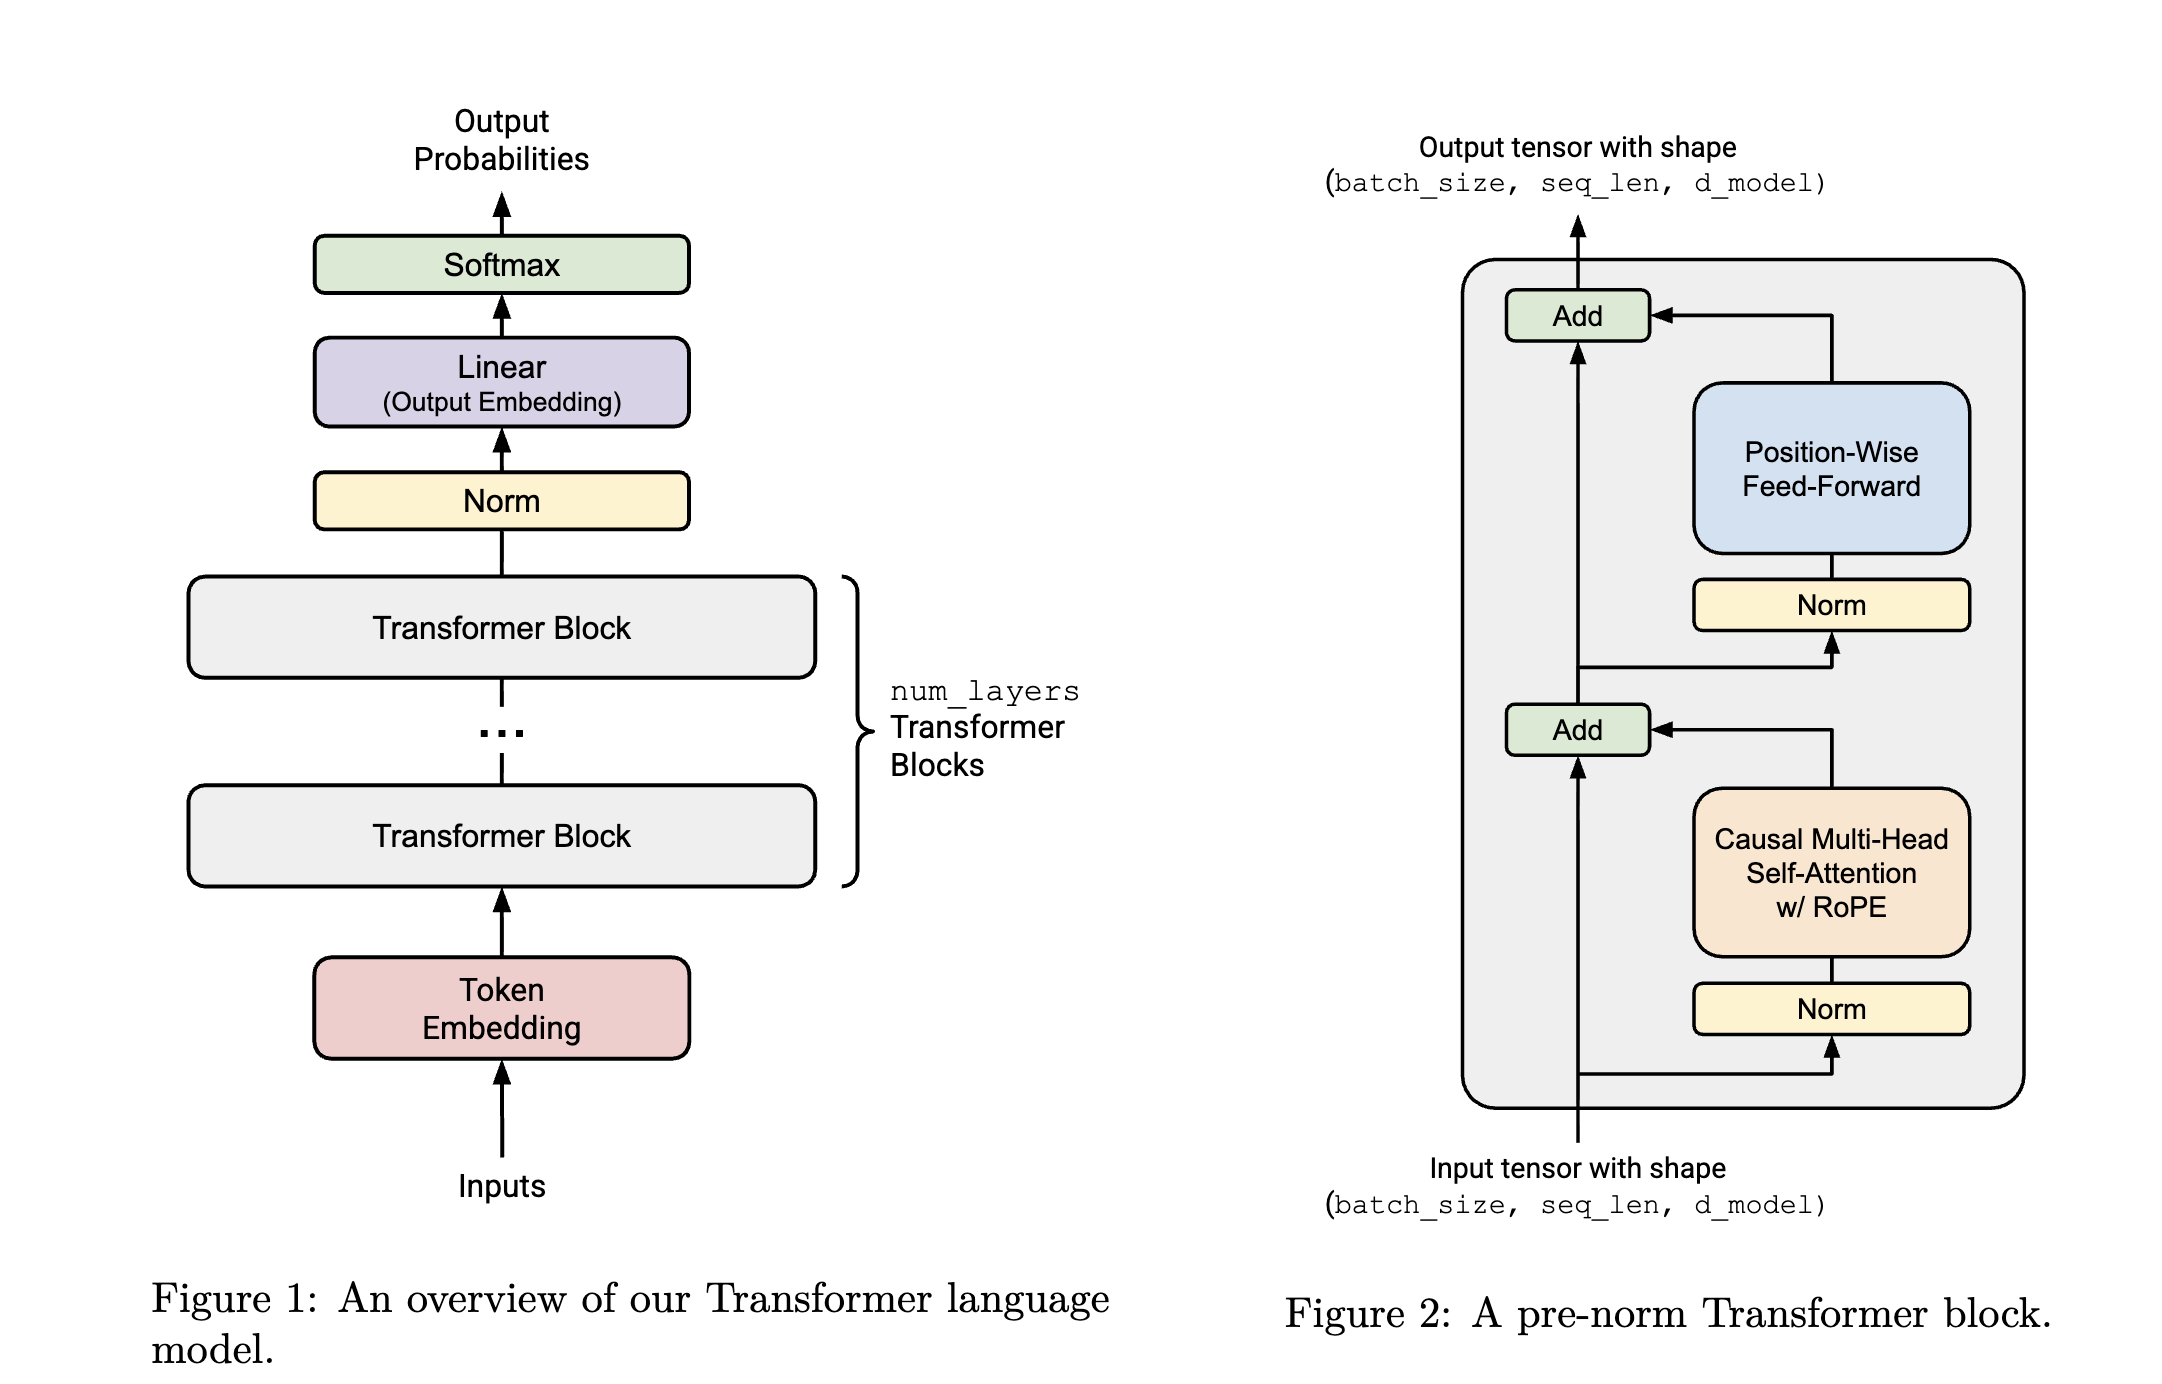

### 3.1 输入阶段:从ID到张量

1. **原始输入**,一批文本经过Tokenizer转换为一个二维整数张量(Tensor)

    - 形状：`[Btach_size,Seq_len]`
    - 例子：`[[332,545,612],[866,956,1402]]`(两个句子，每个三条Token)

2. **面临问题**:整数ID之间没有数学相关性，我们需要将其映射到一个高维连续空间

---

### 3.2映射阶段:embedding层
- **作用**：将整个整数ID转换为一个长度为`d_model`的浮点数向量
- **数学本质**:一个巨大的查找表，`[vocab,d_model]
- **形状变化**：`[B,S]` ->`[B,S,d_model]`
- **意义**：将一个数据摊开，展示更多的隐藏信息，可以更好地对比向量之间的距离

---

### 3.3 Transformer Block
数据进入堆叠的Block，这是模型进行“思考”和“特征提炼”的核心单元。一个Block层包含两个子层

- **负责“交换”的注意力层**:attention
- **负责"特征加工"的前馈网络层**:feed-forward

#### 1.因果多头自注意力(Causal Multi-Head Self-Attention)

---

**自注意力的本质(Q,K,V)**

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

每一个Token向量通过线性变换生成三个向量：

- Query(Q):查询向量，代表当前 token 想要什么信息
- Key(K):键向量，就是每个 token 的"身份标签"
- Value(V):值向量,每个 token 真正携带的信息
- $\sqrt{d_k}$：为了防止梯度消失


❓为什么除以$\sqrt{d_k}$

> "这是为了解决**数值稳定性**问题。
>
> 在计算注意力分数时，我们用 Query 和 Key 做点积。点积操作有一个问题：**它的方差会随着维度 $d_k$ 线性增长**。具体来说，如果 Q 和 K 的每个元素都是均值为 0、方差为 1 的随机变量，那么点积的方差就是 $d_k$。
>
> 举个例子，当 $d_k=512$ 时，点积的标准差会达到 $\sqrt{512} \approx 22.6$，这会导致点积值可能在 ±50 甚至更大的范围内波动。
>
> **这会带来两个严重问题**：
> 1. **Softmax 饱和**：当输入值过大时，Softmax 会输出接近 one-hot 的分布，比如 [0, 0, 0.9999, 0]，注意力过于集中在某一个位置。
> 2. **梯度消失**：Softmax 在饱和区域的梯度接近 0，导致反向传播时梯度消失，模型难以训练。
>
> **解决方法**就是除以 $\sqrt{d_k}$，这样可以把点积的方差归一化到 1，保持 Softmax 的输出分布在一个合理的范围内，梯度也能正常传播。
>
> 至于为什么是 $\sqrt{d_k}$ 而不是 $d_k$，是因为我们要归一化的是**标准差**而不是方差。标准差等于方差的平方根，所以是 $\sqrt{d_k}$。"

---

**多头注意力机制(Multi-Head)**

- 不直接在$d_model$上全维度计算一次注意力，而是将其分为$h$个低维的"头"

- **目的**：允许模型在**不同的子空间**中并行学习，比如head1关注指代关系，head2 focus on temporal relation and the head3 focus on Sentence Structure.


| 步骤 | 操作 | 张量形状 (Tensor Shape) | 技术说明 |
| :-- | :-- | :-- | :-- |
| **1. Input** | **输入输入** | $[B, S, d_{\text{model}}]$ | $B$: Batch Size, $S$: Sequence Length, $d$: Embedding Dim 。 |
| **2. Project** | **线性投影** | $[B, S, d_{\text{model}}]$ | 分别乘以 $W_Q, W_K, W_V$ 得到查询、键、值矩阵 。 |
| **3. Splitting** | **维度拆分** | $[B, h, S, d_{\text{head}}]$ | **Reshape** 为 $[B, S, h, d_{\text{head}}]$ 后 **Transpose** 以便于并行计算 。 |
| **4. Attention** | **因果缩放点积** | $[B, h, S, d_{\text{head}}]$ | 在每个头上应用 Scaled Dot-Product Attention 并加入**因果掩码** 。 |
| **5. Merging** | **多头合并** | $[B, S, d_{\text{model}}]$ | **Concatenate** 所有头，通过输出线性层 $W_O$ 还原至原始隐藏层维度 。 |


---

**因果掩码(Causal Mask)**

单向/因果:只能看到当前位置及之前的 token（过去 + 当前），看不到未来

```sh
输入: "我 爱 吃 苹果"

处理 "吃" 时只能看到:
← 我  爱  [吃]  苹果
  ✓   ✓    ✓    ✗     未来的词被屏蔽
```

普通 Self-Attention（双向）: 可以看到整个序列的所有 token（过去 + 当前 + 未来）

```sh
输入: "我 爱 吃 苹果"

处理 "吃" 时可以看到:
← 我  爱  [吃]  苹果 →
  ✓   ✓    ✓    ✓     所有词都能看到
```

**公式**

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T + M}{\sqrt{d_k}}\right)V
$$

**Causal Mask 矩阵** $M$：

$$
M_{ij} = \begin{cases} 
0 & \text{if } i \geq j \\
-\infty & \text{if } i < j
\end{cases}
$$

注意力权重矩阵（下三角）

$$
\begin{bmatrix}
\alpha_{11} & 0 & 0 & 0 \\
\alpha_{21} & \alpha_{22} & 0 & 0 \\
\alpha_{31} & \alpha_{32} & \alpha_{33} & 0 \\
\alpha_{41} & \alpha_{42} & \alpha_{43} & \alpha_{44}
\end{bmatrix}
$$


**位置编码(RoPE)**

- 得到QK后，对其应用复数域或者旋转矩阵变换
- 给QK注入旋转相位后，他们的点积结构直接收到"相对距离"的影响

---

#### 2.前馈网络(FFN/SwiGLU)

**前馈网络(Feed-Forward Network,FFN)**

本质是两层全连接网络

结构：
  输入 → Linear(升维) → ReLU → Linear(降维) → 输出

  d_model → d_ff(4×) → d_model

公式：
  FFN(x) = ReLU(xW₁ + b₁)W₂ + b₂

三大作用：
  1. 引入非线性（ReLU/GELU）
  2. 独立处理每个 token
  3. 提供模型容量（2/3 参数）

特点：
  ✓ 位置独立（可并行）
  ✓ 参数量大
  ✓ 类似键值记忆库

---

**SwiGLU**(Llama3标配)

加入门控机制

计算过程：

$$
\text{SwiGLU}(x, W, V) = \text{Swish}(xW) \otimes (xV)
$$

其中：
- **Swish 激活**：$\text{Swish}(x) = x \cdot \sigma(x) = \frac{x}{1+e^{-x}}$
- $\otimes$ 表示逐元素乘法
- $xW$ 是**门控信号**（控制开关）
- $xV$ 是**内容信号**（传递信息）



完整版本需要**三个线性层**：

$$
\text{FFN}(x) = (\text{Swish}(xW_1) \otimes xW_2) W_3
$$


```sh
输入 [d_model]
  ↓
  ├→ W1 → Swish → gate [d_ff]
  └→ W2 → value [d_ff]
  ↓
  gate ⊗ value → [d_ff]
  ↓ W3
输出 [d_model]
```


**代码实现**

```python
import torch.nn as nn
import torch.nn.functional as F

class SwiGLU(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff, bias=False)  # gate
        self.w2 = nn.Linear(d_model, d_ff, bias=False)  # value
        self.w3 = nn.Linear(d_ff, d_model, bias=False)  # output
    
    def forward(self, x):
        gate = F.silu(self.w1(x))    # Swish/SiLU
        value = self.w2(x)
        return self.w3(gate * value)  # 门控 + 输出投影
```

**为什么用 SwiGLU？**

1. **性能更好**：实验表明比 ReLU 提升约 2%，比 GELU 提升约 1%
2. **梯度更平滑**：Swish 是连续可导的，训练更稳定
3. **门控机制**：可以动态调节信息流，表达能力更强

**代价与优化**

- **参数量增加 50%**（3个线性层 vs 2个）
- **LLaMA 的解决方案**：将 $d_{ff}$ 从 4× 降到 2.67×，使总参数量接近传统 FFN

**应用**

- LLaMA 全系列
- PaLM
- Chinchilla
- 几乎所有 2023 年后的大模型

---

#### 输出层

经过N层Block之后，输出的张量shape依旧位[B,S,d_model]

1. **最终归一化**：在输出前最后进行一次标准化，稳定梯度

2. **LM Head(线性输出层)**
    - 用一个巨大的**Linear层**，将向量维度从`d_model`映射回`vocab_size`

    - [B,S,d_model] ->[B,S,vocab_size]

3. **Softmax概率化**

    - 对`vocab_size`进行softmax运算，得到每个单词的出现的概率
    - 训练目标：在训练时，我们知道位置t对应的真实标签是t+1。如果模型给真实标签分配的概率越大，交叉熵就越小
